In [ ]:
import re
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np

## PLACE LOG FILE HERE
log_path = "shankar_logging_branching.txt"


# Define all regex patterns
patterns = {
    "prefill_receive": re.compile(r'SHRI Prefill Request (\S+)'),
    "prefill_start": re.compile(r'ROHAN Start of Engine Step Request ID: (\S+)'),
    "prefill_async_start": re.compile(r'ROHAN Prefill Begins Drop Select Handler: (\S+)'),
    "prefill_async_end": re.compile(r'ROHAN Prefill Drop Select Handler End: (\S+)'),
    
    "decode_receive": re.compile(r'SHRI Decode Request (\S+)'),
    "decode_start": re.compile(r'ROHAN Start of Engine Step Request ID: (\S+)'),
    "decode_async_start": re.compile(r'ROHAN Decode Drop Select Start: (\S+)'),
    "decode_async_end": re.compile(r'ROHAN Decode Drop Select End: (\S+)'),

    "end": re.compile(r'SHRI Finished Request ID (\S+)')
}

# Define expected phases per request type
# required_phases = {
#     'Prefill': ['prefill_start', 'prefill_async_start', 'prefill_async_end', 'end'],
#     'Decode': ['decode_start', 'decode_async_start', 'decode_async_end', 'end'],
# }

required_phases = {
    'Prefill': ['prefill_start', 'end'],
    'Decode': ['decode_start', 'end'],
}


def extract_phase_timings(log_file_path):
    request_data = defaultdict(dict)
    request_types = {}  # Map Request ID to type (Prefill or Decode)
    request_comm = defaultdict()
    prefill_comm = 0
    decode_comm = 0

    with open(log_file_path, 'r') as f:
        for line in f:
            timestamp_match = re.search(r'(\d+\.\d+)', line)
            if not timestamp_match:
                continue

            timestamp = float(timestamp_match.group(1))

            for phase, pattern in patterns.items():
                match = pattern.search(line)
                
                if match:
                    if phase == 'prefill_async_start':
                        request_comm["Prefill Async Start Req #" + str(prefill_comm)] = timestamp
                        break
                    elif phase == 'prefill_async_end':
                        request_comm["Prefill Async End Req #" + str(prefill_comm)] = timestamp #- request_comm["Prefill #" + str(prefill_comm)]
                        prefill_comm += 1
                        break
                    elif phase == 'decode_async_start':
                        request_comm["Decode Async Start Req #" + str(decode_comm)] = timestamp
                        break
                    elif phase == 'decode_async_end':
                        request_comm["Decode Async End Req #" + str(decode_comm)] = timestamp #- request_comm["Decode #" + str(decode_comm)]
                        decode_comm += 1
                        break
                    
                    req_id = match.group(1)

                    if req_id in request_types and request_types[req_id] == 'Decode' and phase.startswith('prefill'):
                        # print(f"Skipping Prefill phase for Request ID {req_id} as it is already marked as Decode")
                        continue 
                    if req_id in request_types and request_types[req_id] == 'Prefill' and phase.startswith('decode'):
                        # print(f"Skipping Decode phase for Request ID {req_id} as it is already marked as Prefill")
                        continue 
                    
                    if req_id in request_data and phase in request_data[req_id]:
                        continue  # Skip if already recorded
                    # print(f"Found {phase} for Request ID {req_id} at {timestamp:.6f}")
                    request_data[req_id][phase] = timestamp

                    if phase.startswith('prefill'):
                        # print(phase)
                        # print(f"Found Prefill phase for Request ID {req_id} at {timestamp:.6f}")
                        request_types[req_id] = 'Prefill'
                    elif phase.startswith('decode'):
                        request_types[req_id] = 'Decode'
                    break

    # Compute durations
    durations = []
    
    for req_id, times in request_data.items():
        req_type = request_types.get(req_id)
        if not req_type:
            continue
        phases = required_phases[req_type]

        # for p in phases:
        #     if p not in times:
        #         print(times)

        if all(p in times for p in phases):
            if req_type == 'Prefill':
                durations.append({
                    'id': req_id,
                    'type': req_type,
                    'start_to_end': times['end'] - times['prefill_start'],
                    'start': times['prefill_start'],
                    'end': times['end'],
                    # 'async_duration': times['prefill_async_end'] - times['prefill_async_start'],
                    # 'engine_to_async_start': times['prefill_async_start'] - times['prefill_start'],
                })
            elif req_type == 'Decode':
                durations.append({
                    'id': req_id,
                    'type': req_type,
                    'start_to_end': times['end'] - times['decode_start'],
                    'start': times['decode_start'],
                    'end': times['end'],
                    # 'async_duration': times['decode_async_end'] - times['decode_async_start'],
                    # 'engine_to_async_start': times['decode_async_start'] - times['decode_start'],
                    # 'async_end_to_finish': times['end'] - times['decode_async_end']
                })

    # print(durations)
    return durations, request_comm

# def visualize_phase_durations(durations):
#     prefill = [d for d in durations if d['type'] == 'Prefill']
#     decode = [d for d in durations if d['type'] == 'Decode']

#     def plot_phase(data, label):
#         ids = range(len(data))
#         start_to_end = [d['start_to_end'] for d in data]
#         # async_dur = [d['async_duration'] for d in data]
#         # to_async = [d['engine_to_async_start'] for d in data]
#         # from_async = [d['async_end_to_finish'] for d in data]

#         plt.figure(figsize=(12, 6))
#         plt.plot(ids, start_to_end, label='Total Duration')
#         # plt.plot(ids, async_dur, label='Async Duration')
#         # plt.plot(ids, to_async, label='Start to Async Start')
#         # plt.plot(ids, from_async, label='Async End to Finish')
#         plt.title(f'{label} Request Timing Breakdown')
#         plt.xlabel('Request Index')
#         plt.ylabel('Duration (seconds)')
#         plt.legend()
#         plt.grid(True, linestyle='--', alpha=0.6)
#         plt.tight_layout()
#         plt.savefig(f'TimePlots/{label.lower()}_phases.png', dpi=300)
#         plt.show()

#     if prefill:
#         plot_phase(prefill, 'Prefill')
#     if decode:
#         plot_phase(decode, 'Decode')

# Run the full process
log_lines = []


durations, request_comm = extract_phase_timings(log_path)

print(f"\nTotal completed requests with all phase timings: {len(durations)}")
offset = durations[0]['start']
for d in durations:
    # print(f"{d['type']} ID {d['id']}: Total={d['start_to_end']:.6f}s, Async={d['async_duration']:.6f}s, "
    #       f"ToAsync={d['engine_to_async_start']:.6f}s, FromAsync={d['async_end_to_finish']:.6f}s")

    print(f"{d['type']} ID {d['id']}: Start={d['start']-offset:.6f}s, End={d['end']-offset:.6f}s")
    log_lines.append(f"{d['type']} ID {d['id']}: Start={d['start']-offset:.6f}s, End={d['end']-offset:.6f}s")

for req, time in request_comm.items():
    print(f"{req} communication timestamp: {time-offset:.6f}s")
    log_lines.append(f"{req} communication timestamp: {time-offset:.6f}s")



Total completed requests with all phase timings: 20
Prefill ID cmpl-cc889066039c46809edd416da0ec6d23-0: Start=0.000000s, End=0.075097s
Prefill ID cmpl-bd5afe55d3c94ed09163df05a677d23e-0: Start=0.065432s, End=0.193017s
Decode ID cmpl-c151349bdb304b2aa6940d7bb21a8d0f-0: Start=0.099591s, End=2.466794s
Prefill ID cmpl-9ba6425f9ffa4bfbb439d52d85131ceb-0: Start=0.134004s, End=0.219875s
Decode ID cmpl-2e01bb56907442ae90913c78f66086da-0: Start=0.218422s, End=2.466894s
Decode ID cmpl-51ac9b36cb8b4350aa068297a61ef427-0: Start=0.244001s, End=2.466976s
Prefill ID cmpl-824a1cd5640e41dda3ac04d79f9190b2-0: Start=0.320674s, End=0.385624s
Decode ID cmpl-daec8693dd8b4e65b707e71536b339e0-0: Start=0.398439s, End=2.550844s
Prefill ID cmpl-ab6bec2581fb464a8e4867046878aef5-0: Start=0.494580s, End=0.569618s
Prefill ID cmpl-8881b99d74f543f297dfaf45df78d4a8-0: Start=0.559681s, End=0.629511s
Decode ID cmpl-a335dd094c2e4574b8414221b53784cc-0: Start=0.585015s, End=2.733238s
Prefill ID cmpl-0ac95066306b46dbab3ad69

In [35]:
import re
import matplotlib.pyplot as plt

# Example log lines (you can read these from your file instead)
# log_lines = [
#     # Summary lines (20 total)
#     "Prefill ID cmpl-5fa9913008e948f88efc0f6c77ebf275-0: Start=0.000000s, End=0.074578s",
#     "Prefill ID cmpl-350065b99645453fa593a38f75fd130d-0: Start=0.065356s, End=0.196440s",
#     "Decode ID cmpl-1d862d638479444ca96f90ee1842b458-0: Start=0.100188s, End=2.221304s",
#     "Prefill ID cmpl-966a28d1b0b14648805e7ca83ee84f9c-0: Start=0.134376s, End=0.225972s",
#     "Decode ID cmpl-ecdb3cac0fd54ab78cd25589d04f4282-0: Start=0.227201s, End=1.769933s",
#     "Decode ID cmpl-9d3b71891c71433b8e290fe49e2f07fc-0: Start=0.250413s, End=2.221377s",
#     "Prefill ID cmpl-b0e32c2c065b4e16a95f61c71076ea8b-0: Start=0.261163s, End=0.326071s",
#     "Decode ID cmpl-2546646d04584deeade9708ea67b45c7-0: Start=0.340605s, End=0.384994s",
#     "Prefill ID cmpl-41083d5d71d148508de36aeb96c101fb-0: Start=0.498417s, End=0.571894s",
#     "Prefill ID cmpl-1a8f72b40ab248348323678a0c1b41fb-0: Start=0.563183s, End=0.633065s",
#     "Decode ID cmpl-66af0d4e62e64f908203febc2da74cd0-0: Start=0.587366s, End=2.545106s",
#     "Prefill ID cmpl-224f9b92f54e49388d3cabd36d7491ea-0: Start=0.654403s, End=0.736692s",
#     "Decode ID cmpl-54fd454b34e04f0890be2d400b0e3aa2-0: Start=0.656126s, End=2.545186s",
#     "Prefill ID cmpl-025d8bfe5d7545159969d4396712c469-0: Start=0.727868s, End=0.805740s",
#     "Decode ID cmpl-041c463fd9774f92b8863eb9e29c7f5e-0: Start=0.745446s, End=2.561122s",
#     "Prefill ID cmpl-26cb94d6ab9144f7a0d35f4e4898303a-0: Start=0.795824s, End=0.872877s",
#     "Decode ID cmpl-2e757b97d2574b67924305f4dee9ac26-0: Start=0.823658s, End=2.577188s",
#     "Decode ID cmpl-71bd97acbe8940cfa4fc942d4bd37f57-0: Start=0.895925s, End=2.577269s",
#     "Prefill ID cmpl-2009ddeb51a34b1f90a81db7aaf72d9e-0: Start=0.949271s, End=1.014502s",
#     "Decode ID cmpl-7fd54645c9f34564b4195b7fa00d11c2-0: Start=1.026637s, End=1.075885s",
#     # Async lines (10 groups, 4 lines per group)
#     "Decode Async Start Req #0 communication timestamp: 0.101810s",
#     "Prefill Async Start Req #0 communication timestamp: 0.103161s",
#     "Prefill Async End Req #0 communication timestamp: 0.190367s",
#     "Decode Async End Req #0 communication timestamp: 0.199079s",
#     "Decode Async Start Req #1 communication timestamp: 0.228003s",
#     "Prefill Async Start Req #1 communication timestamp: 0.229201s",
#     "Prefill Async End Req #1 communication timestamp: 0.241323s",
#     "Decode Async End Req #1 communication timestamp: 0.242284s",
#     "Decode Async Start Req #2 communication timestamp: 0.251355s",
#     "Prefill Async Start Req #2 communication timestamp: 0.252148s",
#     "Prefill Async End Req #2 communication timestamp: 0.253143s",
#     "Decode Async End Req #2 communication timestamp: 0.253936s",
#     "Decode Async Start Req #3 communication timestamp: 0.341335s",
#     "Prefill Async Start Req #3 communication timestamp: 0.342439s",
#     "Prefill Async End Req #3 communication timestamp: 0.343904s",
#     "Decode Async End Req #3 communication timestamp: 0.344708s",
#     "Decode Async Start Req #4 communication timestamp: 0.588106s",
#     "Prefill Async Start Req #4 communication timestamp: 0.589211s",
#     "Prefill Async End Req #4 communication timestamp: 0.633178s",
#     "Decode Async End Req #4 communication timestamp: 0.634708s",
#     "Decode Async Start Req #5 communication timestamp: 0.656834s",
#     "Prefill Async Start Req #5 communication timestamp: 0.657910s",
#     "Prefill Async End Req #5 communication timestamp: 0.718944s",
#     "Decode Async End Req #5 communication timestamp: 0.719720s",
#     "Decode Async Start Req #6 communication timestamp: 0.746271s",
#     "Prefill Async Start Req #6 communication timestamp: 0.747765s",
#     "Prefill Async End Req #6 communication timestamp: 0.797215s",
#     "Decode Async End Req #6 communication timestamp: 0.798320s",
#     "Decode Async Start Req #7 communication timestamp: 0.824384s",
#     "Prefill Async Start Req #7 communication timestamp: 0.825308s",
#     "Prefill Async End Req #7 communication timestamp: 0.872236s",
#     "Decode Async End Req #7 communication timestamp: 0.873612s",
#     "Decode Async Start Req #8 communication timestamp: 0.896742s",
#     "Prefill Async Start Req #8 communication timestamp: 0.897814s",
#     "Prefill Async End Req #8 communication timestamp: 0.898900s",
#     "Decode Async End Req #8 communication timestamp: 0.900036s",
#     "Decode Async Start Req #9 communication timestamp: 1.027442s",
#     "Prefill Async Start Req #9 communication timestamp: 1.029203s",
#     "Prefill Async End Req #9 communication timestamp: 1.030589s",
#     "Decode Async End Req #9 communication timestamp: 1.031378s",
# ]



In [36]:
# Patterns to parse the log lines
summary_re = re.compile(r'^(Prefill|Decode) ID (\S+): Start=(\d+\.\d+)s, End=(\d+\.\d+)s')
async_re = re.compile(r'^(Prefill|Decode) Async (Start|End) Req #(\d+) communication timestamp: (\d+\.\d+)s')

# Containers for parsed data
summary_data = []  # list of dicts: each has type, id, start, end
async_data = {}    # grouped by request number; each group holds separate entries for Prefill and Decode

# Parse each log line
for line in log_lines:
    line = line.strip()
    m = summary_re.match(line)
    if m:
        req_type, req_id, start, end = m.groups()
        summary_data.append({
            'type': req_type,
            'id': req_id,
            'start': float(start),
            'end': float(end)
        })
        continue
    m = async_re.match(line)
    if m:
        async_type, event, req_num, ts = m.groups()
        req_num = int(req_num)
        if req_num not in async_data:
            async_data[req_num] = {}
        # We store separately for each type (Prefill and Decode)
        if async_type not in async_data[req_num]:
            async_data[req_num][async_type] = {}
        async_data[req_num][async_type][event.lower()] = float(ts)




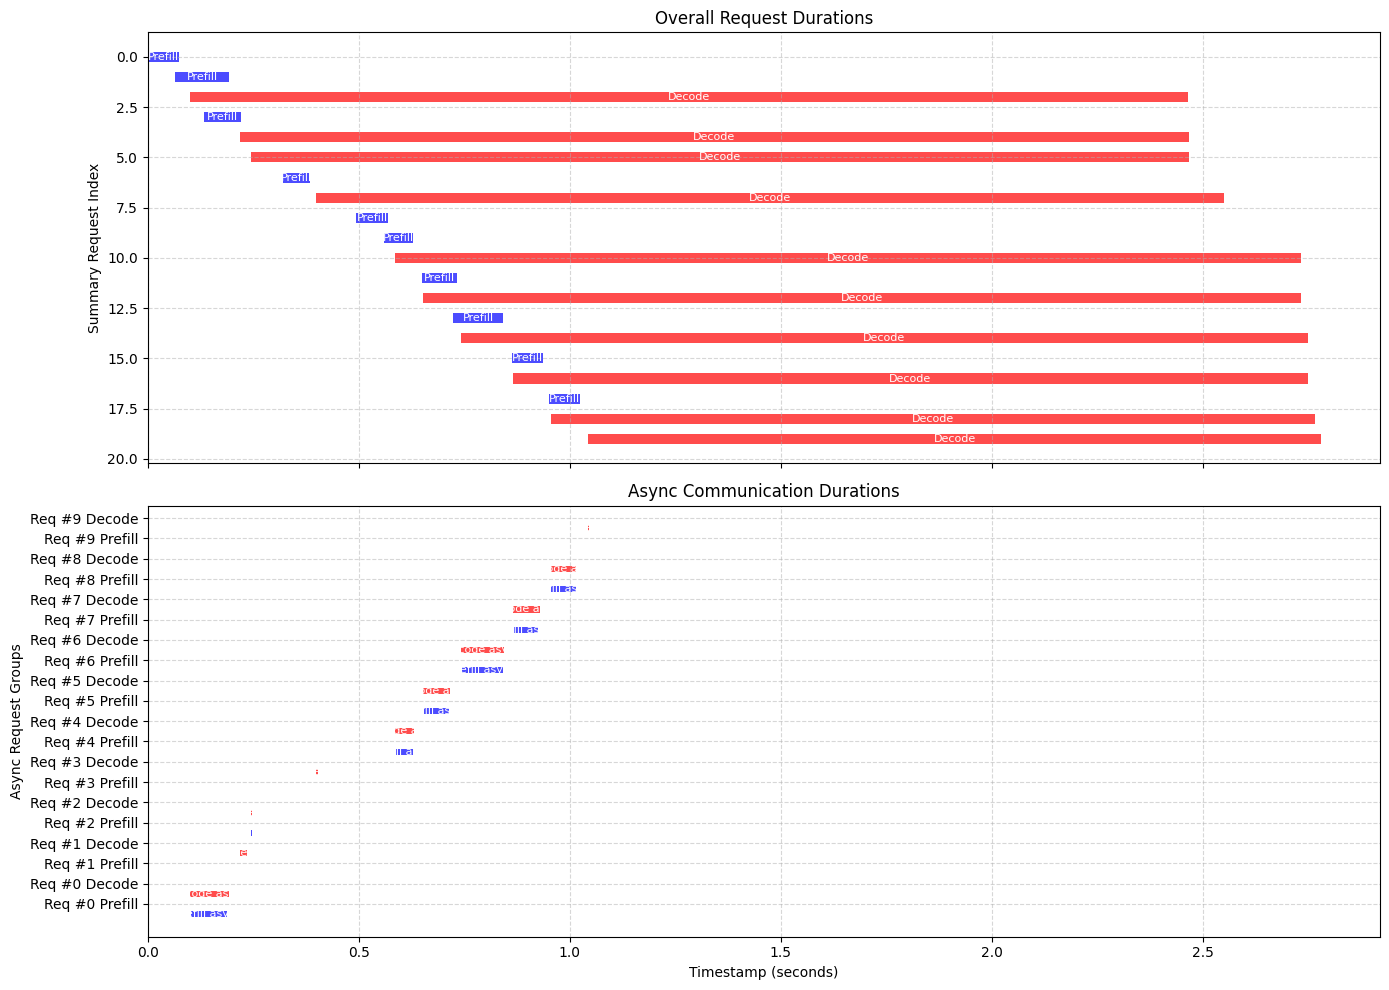

In [37]:
# Now, produce the timeline visualization.

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(14, 10))

###########
# Plot summary data (overall request durations)
###########
# Sort summary_data by start time for visual clarity.
summary_data = sorted(summary_data, key=lambda x: x['start'])

# We'll assign each request an index (y position)
for i, d in enumerate(summary_data):
    duration = d['end'] - d['start']
    # Choose a color based on the type
    color = 'blue' if d['type'] == 'Prefill' else 'red'
    ax1.barh(i, duration, left=d['start'], height=0.5, color=color, alpha=0.7)
    ax1.text(d['start'] + duration/2, i, d['type'], va='center', ha='center', color='white', fontsize=8)
    
ax1.set_ylabel("Summary Request Index")
ax1.set_title("Overall Request Durations")
ax1.invert_yaxis()  # so the earliest request is at the top
ax1.grid(True, linestyle='--', alpha=0.5)

###########
# Plot async communication intervals
###########
# For the async data, we assume each group (by Req #) has two bars: one for Prefill and one for Decode.
# We place them on separate rows per group.
y_pos = []
y_labels = []
async_bar_height = 0.3

for req_num in sorted(async_data.keys()):
    grp = async_data[req_num]
    base_y = req_num * 2  # each request gets two rows
    # Plot for Prefill if available
    if 'Prefill' in grp and 'start' in grp['Prefill'] and 'end' in grp['Prefill']:
        start = grp['Prefill']['start']
        duration = grp['Prefill']['end'] - start
        ax2.barh(base_y, duration, left=start, height=async_bar_height, color='blue', alpha=0.7)
        ax2.text(start + duration/2, base_y, "Prefill async", va='center', ha='center', color='white', fontsize=8)
    # Plot for Decode if available
    if 'Decode' in grp and 'start' in grp['Decode'] and 'end' in grp['Decode']:
        start = grp['Decode']['start']
        duration = grp['Decode']['end'] - start
        ax2.barh(base_y+1, duration, left=start, height=async_bar_height, color='red', alpha=0.7)
        ax2.text(start + duration/2, base_y+1, "Decode async", va='center', ha='center', color='white', fontsize=8)
    
    # Record labels
    y_labels.append(f"Req #{req_num} Prefill")
    y_labels.append(f"Req #{req_num} Decode")

ax2.set_ylabel("Async Request Groups")
ax2.set_title("Async Communication Durations")
ax2.set_yticks([i+0.5 for i in range(0, (len(async_data)*2))])
ax2.set_yticklabels(y_labels)
ax2.grid(True, linestyle='--', alpha=0.5)

# Set x-axis label on the bottom subplot
ax2.set_xlabel("Timestamp (seconds)")

plt.tight_layout()
plt.show()